In [1]:
import anndata
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from models import pmVAEModel

In [2]:
from utils import load_annotations
from sklearn.model_selection import train_test_split

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt

# load data

In [3]:
rna_seq = pd.read_csv('data/alzheimers-disease-gene-modules-master-data-preprocessed_data/data/preprocessed_data/All_Datasets_Preprocessed_Expression_Matrix.tsv',sep='\t',index_col=0)
abeta_data = pd.read_csv('data/alzheimers-disease-gene-modules-master-data-preprocessed_data/data/preprocessed_data/All_Datasets_Abeta_IHC_Labels.tsv',index_col=0,sep='\t')

/homes/gws/jjanizek/anaconda3/envs/new_torch/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
dataset_labels = pd.read_csv('data/alzheimers-disease-gene-modules-master-data-preprocessed_data/data/preprocessed_data/All_Dataset_Labels.tsv',index_col=0,sep='\t')

In [5]:
# filter microarray data
microarray = dataset_labels['Dataset Label'] == "MSBB_MICROARRAY"
X = rna_seq.loc[~microarray.values,:]

In [7]:
assignment_mat = load_annotations(
    'data/h.all.v7.4.symbols.gmt',
    X.columns,
    min_genes=20
)

In [8]:
membership_mask = assignment_mat.astype(bool).T

In [9]:
from torch.utils.data import Dataset, DataLoader
class RNASeqData(Dataset):
    
    def __init__(self, X, c=None, y=None, transform=None):
        self.X = X
        self.y = y
        self.c = c
        self.transform = transform
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        sample = self.X[index,:]
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        if self.y is not None and self.c is not None:
            return sample, self.y[index], self.c[index]
        if self.y is None and self.c is not None:
            return sample, self.c[index]
        else:
            return sample

In [10]:
from sklearn.preprocessing import OneHotEncoder

region_labels = pd.read_csv('data/alzheimers-disease-gene-modules-master-data-preprocessed_data/data/preprocessed_data/All_Joined_Region_Labels.tsv',index_col=0,sep='\t')


enc = OneHotEncoder()
c_array = np.concatenate((region_labels.Region.values.reshape(-1,1),
                          dataset_labels['Dataset Label'].values.reshape(-1,1)),axis=1)

enc.fit(c_array)

pre_processed_c_array = enc.transform(c_array).toarray()

microarray = dataset_labels['Dataset Label'] == "MSBB_MICROARRAY"

X = rna_seq.loc[~microarray.values,:]
pre_processed_c_array = pre_processed_c_array[~microarray,:]

assignment_mat = load_annotations(
    'data/h.all.v7.4.symbols.gmt',
    X.columns,
    min_genes=20
)

membership_mask = assignment_mat.astype(bool).T

In [11]:
membership_mask = assignment_mat.astype(bool).T
X_train, X_test, c_train, c_test = train_test_split(
    X, pre_processed_c_array,
    test_size=0.25,
    shuffle=True,
    random_state=0,
)

In [14]:
train_ds = RNASeqData(X_train.values, c=c_train)
test_ds = RNASeqData(X_test.values, c=c_test)

# load trained cpmVAE Model

In [12]:
from models import pmVAEModel

In [13]:
ADVAE = pmVAEModel(
    membership_mask.values,
    [12],
    4,
    cdim = c_train.shape[1],
    hsic_penalty=1.0e6,
    beta=1e-02,
    terms=membership_mask.index,
    add_auxiliary_module=True
)

In [16]:
i=2
ADVAE.load_checkpoint('pmvae_HSIC_4d_repeat_' + str(i) + '_030222.pkl.best_loss')

In [17]:
abeta_data = pd.read_csv('data/alzheimers-disease-gene-modules-master-data-preprocessed_data/data/preprocessed_data/All_Datasets_Abeta_IHC_Labels.tsv',index_col=0,sep='\t')

# look at only samples with associated ABETA IHC and measure predictive perf

In [18]:
train_indices_label = []
for i,x in enumerate(abeta_data.index):
    if x in X.index:
        train_indices_label.append(x)

In [19]:
X.index = X.index.rename('sample_name')

In [20]:
X_labeled = X.loc[train_indices_label,:].groupby('sample_name').mean()

In [21]:
X_labeled.shape

(664, 16252)

In [22]:
y = abeta_data.loc[train_indices_label,'ABETA_IHC'].groupby('sample_name').mean().fillna(0)

In [25]:
outputs = ADVAE.model(torch.tensor(X.values).cuda().float(),
                      torch.tensor(pre_processed_c_array).cuda().float())

latent_space = pd.DataFrame(
    outputs.z.detach().cpu().numpy(),
    index=X.index,
    columns=ADVAE.latent_space_names())

In [27]:
latent_space.index = latent_space.index.rename('sample_name')
labeled_embedding = latent_space.loc[train_indices_label,:].groupby('sample_name').mean()

In [28]:
## for 20 random train test splits, compare the best held out test set MSE for
## abeta IHC prediction attained by models trained on original full gene expression space
## to the MSE attained by models trained on the latent embeddings

from sklearn.linear_model import LassoCV,RidgeCV
from scipy.stats import spearmanr

pure_gene_spearman = []
mean_pathway_spearman = []
pca_spearman = []
embedding_spearman = []
for random_seed in range(20):
    
    new_X_train,new_X_test,new_y_train,new_y_test = train_test_split(X_labeled,y,random_state=random_seed)
    lm = RidgeCV(alphas=[1e-3,1e-2,1e-1,1e0,1e1,1e2])
    lm.fit(new_X_train,new_y_train)
    pure_gene_spearman.append(spearmanr(lm.predict(new_X_test),new_y_test).correlation)
    
    new_X_train,new_X_test,new_y_train,new_y_test = train_test_split(labeled_embedding,y,random_state=random_seed)
    lm = RidgeCV(alphas=[1e-3,1e-2,1e-1,1e0,1e1,1e2])
    lm.fit(new_X_train,new_y_train)
    embedding_spearman.append(spearmanr(lm.predict(new_X_test),new_y_test).correlation)

In [30]:
N = 20
method_list = ['Gene Space']*N + ['pmVAE Embedding']*N
spearman_corr = np.concatenate([np.array(pure_gene_spearman).reshape(-1,1),
                                np.array(embedding_spearman).reshape(-1,1)],axis=0)
plotting_frame=pd.DataFrame()
plotting_frame['method'] = method_list
plotting_frame['correlation'] = spearman_corr

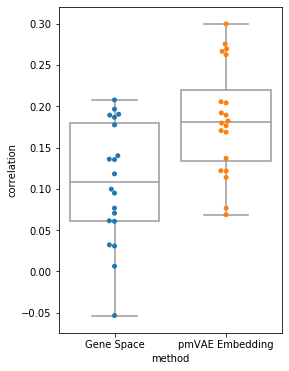

In [31]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.figure(figsize=(4,6))
sb.boxplot(data=plotting_frame,x='method',y='correlation',color='white')
sb.swarmplot(data=plotting_frame,x='method',y='correlation')
# plt.ylim([500,975])

In [32]:
from scipy.stats import ttest_rel,ttest_ind
ttest_rel(embedding_spearman,pure_gene_spearman)

Ttest_relResult(statistic=4.296741225571716, pvalue=0.0003892571135355866)

In [33]:
from scipy.stats import ranksums
ranksums(embedding_spearman,pure_gene_spearman)

RanksumsResult(statistic=2.8132092601623886, pvalue=0.00490497196539969)

# Interpret Pathways

In [28]:
from pathexplainer import PathExplainerTorch

In [29]:
ADVAE.set_gpu(False)

In [30]:
import torch.nn.functional as F
def model_loss_wrapper(z):
    latent_input = torch.cat([z, c_full], 1)
    module_outputs = ADVAE.model.decoder_net(latent_input)
    global_recon = ADVAE.model.merge(module_outputs)
    return F.mse_loss(global_recon, ground_truth, reduction='none').mean(1).view(-1,1)

In [31]:
ground_truth = torch.tensor(X.values).float()
c_full = torch.tensor(pre_processed_c_array).float()
outs = ADVAE.model(ground_truth,c_full)

In [32]:
input_data = outs.z
baseline_data = torch.zeros(outs.z.shape[1])
baseline_data.requires_grad = True

In [33]:
explainer = PathExplainerTorch(model_loss_wrapper)
attributions = explainer.attributions(input_data,
                                      baseline=baseline_data,
                                      num_samples=200,
                                      use_expectation=False)

In [34]:
np_attribs = attributions.detach().numpy()
top_features = pd.DataFrame(index=ADVAE.latent_space_names())
top_features['ma_shap'] = np_attribs.mean(0)
top_features['std_shap'] = np_attribs.std(0)

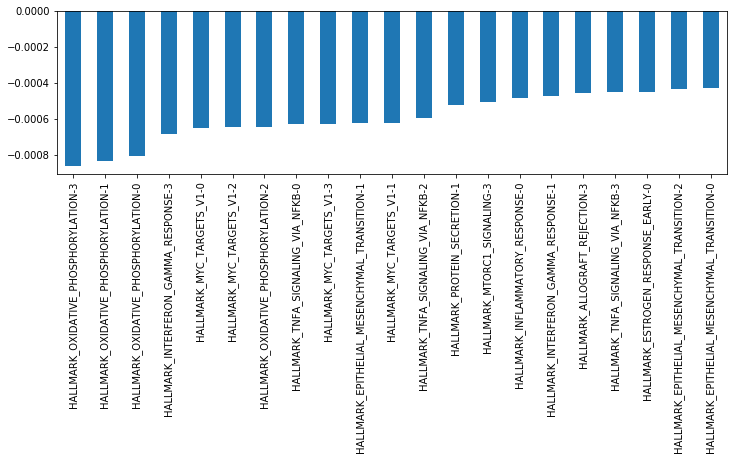

In [35]:
# Loss explanation
top_features.sort_values('ma_shap',ascending=True).iloc[4:25,0].plot.bar(figsize=(12,3))

In [55]:
# Loss explanation
top_20 = top_features.sort_values('ma_shap',ascending=True).iloc[4:24,:]

In [66]:
pathway_labels = [x.split('HALLMARK_')[1].title().replace('_', ' ').replace('Myc','MYC') for x in top_20.index]

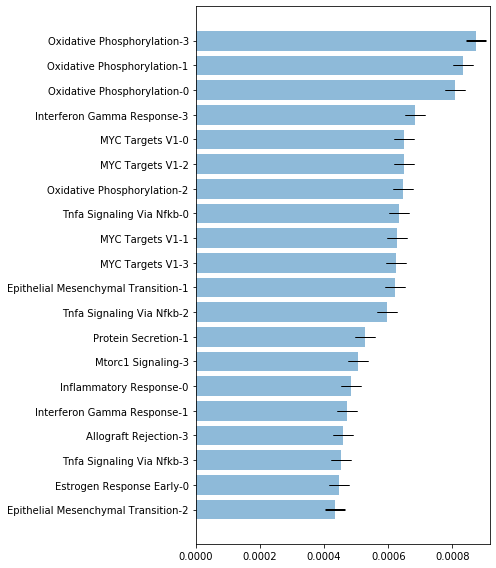

In [72]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(7,8))
ax.barh(20-np.arange(20), -1*top_20['ma_shap'].values, yerr=top_20['std_shap'].values, 
        align='center', alpha=0.5, ecolor='black', capsize=10)
# ax.set_ylabel('Coefficient of Thermal Expansion ($\degree C^{-1}$)')
# ax.set_xticks(x_pos)
ax.set_yticks(20-np.arange(20))
ax.set_yticklabels(pathway_labels)
# ax.set_xticklabels(materials)
# ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
# ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.savefig('Fig5PathwayBarPlot.pdf')
plt.show()

In [36]:
ADVAE.latent_space_names().index('HALLMARK_OXIDATIVE_PHOSPHORYLATION-3')

135

In [37]:
# explain aux 0 in terms of genes

def model_latent_wrapper(x):
    outs = ADVAE.model(x,c_full)
    z = outs.mu
    return z[:,135].reshape(-1,1)

In [38]:
input_data = torch.tensor(X.values).float()
input_data.requires_grad = True
baseline_data = torch.zeros(X.shape[1])
baseline_data.requires_grad = True

In [39]:
explainer = PathExplainerTorch(model_latent_wrapper)
attributions = explainer.attributions(input_data,
                                      baseline=baseline_data,
                                      num_samples=200,
                                      use_expectation=False)

In [40]:
np_attribs = attributions.detach().numpy()
top_features = pd.DataFrame(index=membership_mask.columns)
top_features['ma_shap'] = np.abs(np_attribs).mean(0)

In [71]:
from summary import summary_plot

In [72]:
from matplotlib import cm
import matplotlib.pyplot as plt

coolwarm = cm.get_cmap('coolwarm')

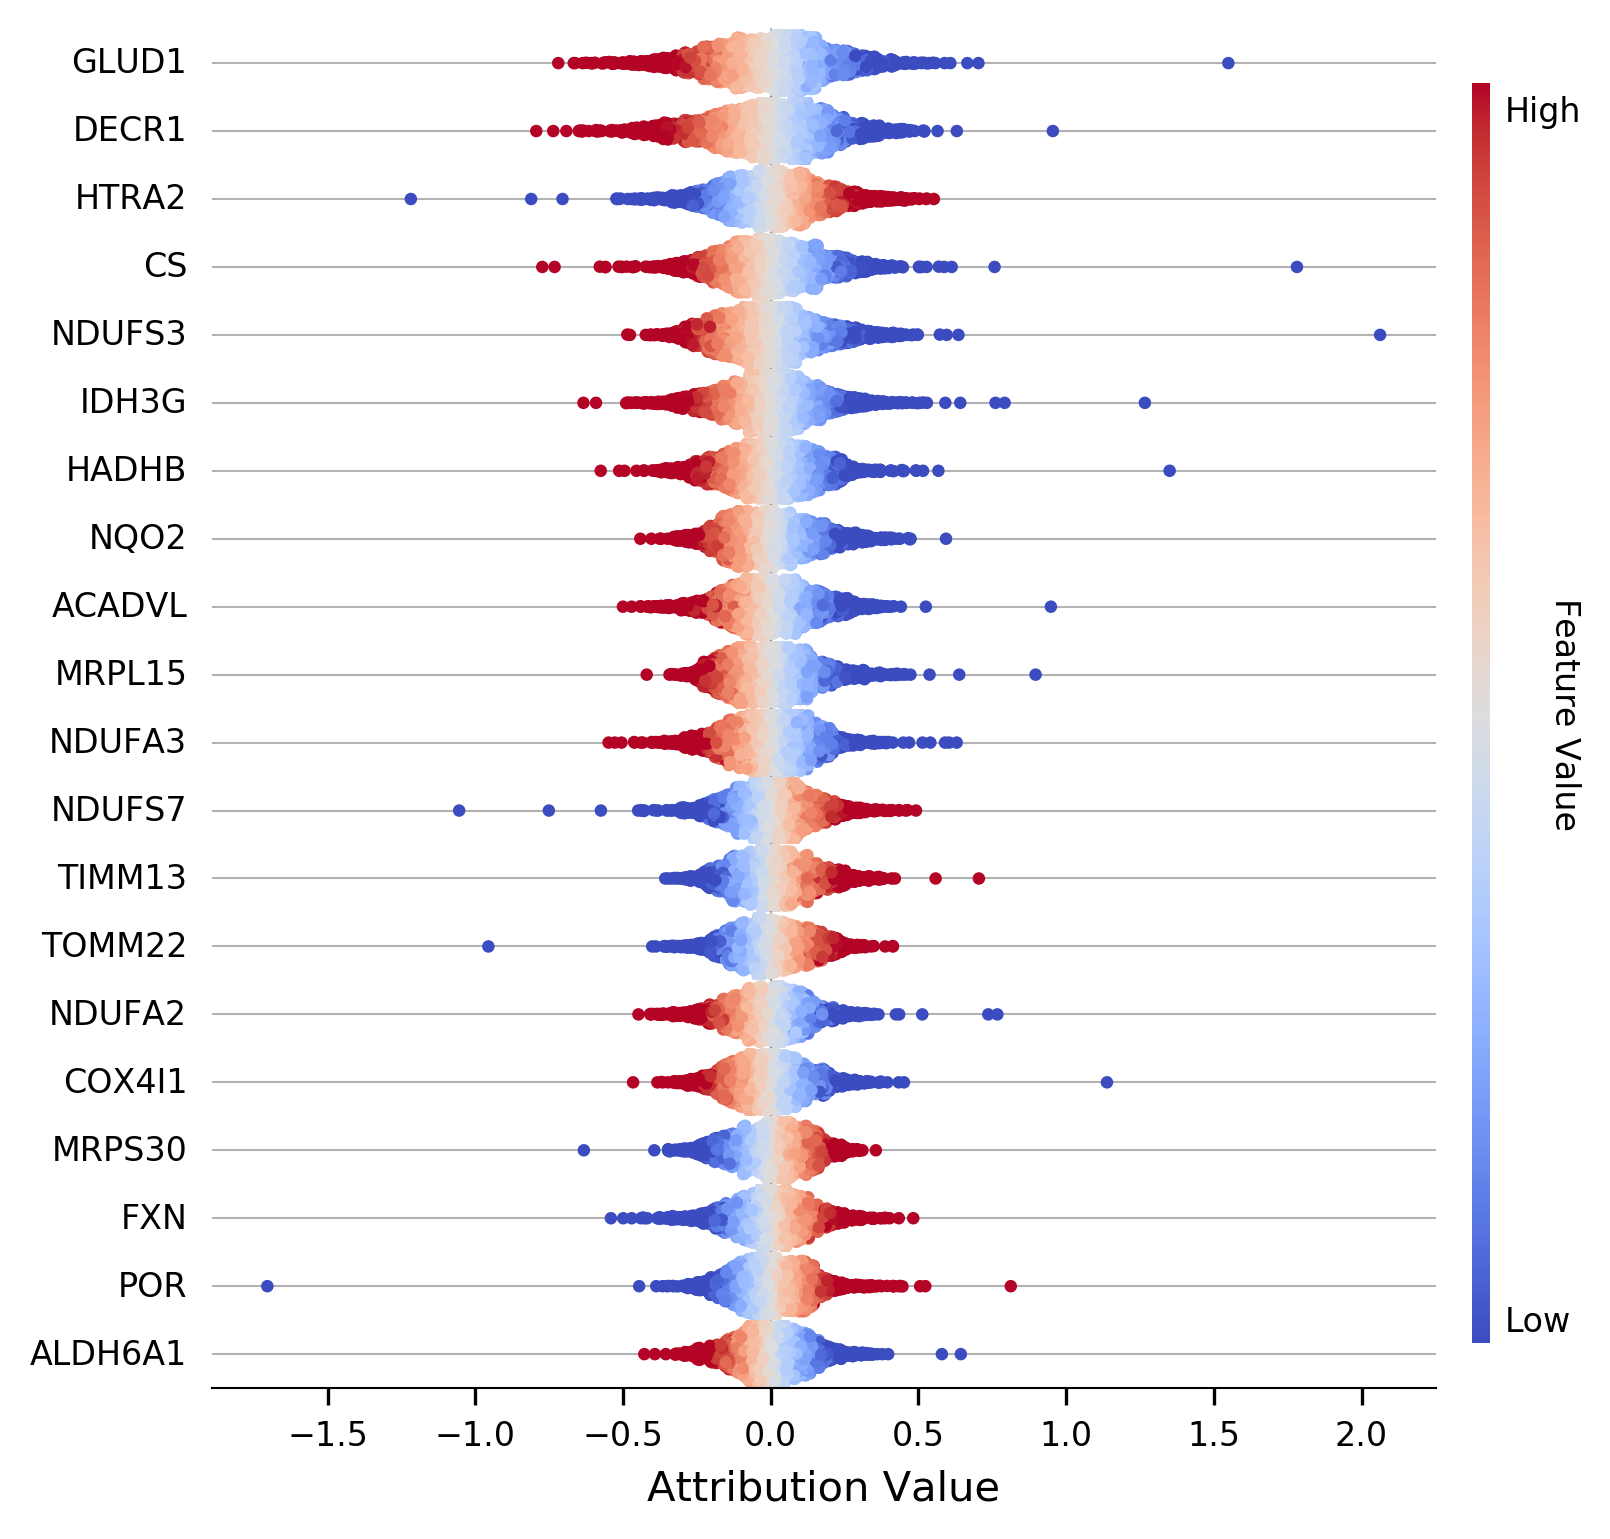

In [74]:
summary_plot(np_attribs,
             X.values,
             feature_names=X.columns,
             plot_top_k=20,
             standardize_features=False,
             scale_x_ind=False,
             scale_y_ind=False,
             figsize=(6, 6),
             dpi=300,
             cmap=coolwarm)